In [1]:
import warnings
warnings.filterwarnings("ignore")

import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rc('pdf', fonttype=42) # Avoid type 3 fonts

sns.set_theme(style="white")
sns.set_palette(sns.color_palette("tab10"))
plt.rcParams.update({"xtick.bottom" : True}) # enables ticks

In [2]:
BASE_DIR = '../android/'
RESULTS_DIR = os.path.join(BASE_DIR, '../results/small-hw-support-2024-05-25-125045/')

TESTS = {
    "small": "testBenchLongSloth_withOwasp_small",
    "large": "testBenchLongSloth_withOwasp_large",
}


def read_device_info(path):
    with open(path) as f:
        x = json.load(f)
        
    name = x['name'].replace('"', '')
    name = name.replace(' 5G', '')
        
    os = x['os']
    if '.' in os:
        os = os[:os.find('.')]
    
    return {
        'name': name,
        'os': int(os),
    }


def read_sloth_bench_results(dir_path, test_name):
    allL, allDurations = [], []
    
    with open(os.path.join(dir_path, f'{test_name}.json')) as f:
        x = json.load(f)
        
        for m in x:
            d = m['data']
            if m['tag'] != 'LogTracer' or test_name not in d:
                continue
            _, _, l, _, _, afterPwHashNs, _, finishNs = d.split(' ')
    
            allL.append(int(l.split('=')[1]))
        
            afterPwHashNs = int(afterPwHashNs.split('=')[1])
            finishNs = int(finishNs.split('=')[1])
            allDurations.append((finishNs - afterPwHashNs) / 1_000_000) # NS to MS
    
    return {
        'l': allL,
        'duration': allDurations, 
    }


def read_job_result(job_name, job_path, test_id, test_name):
    device_info = read_device_info(os.path.join(job_path, "device.json"))
    bench_results = read_sloth_bench_results(job_path, test_name)
    
    return {**device_info, **{'test': test_id}, **bench_results}

                  
def read_all_jobs():
    all_data = []
    for job_name in sorted(os.listdir(RESULTS_DIR)):
        job_path = os.path.join(RESULTS_DIR, job_name)
        
        if not os.path.isdir(job_path):
            continue
            
        for test_id, test_name in TESTS.items():
            x = read_job_result(job_name, job_path, test_id, test_name)
            if len(x['l']) < 10: continue
            all_data.append(x)
    return pd.json_normalize(all_data)
        
df = read_all_jobs()
df = df.explode(['l', 'duration'], ignore_index=True)
df = df.astype({'duration': 'float64'})

df.sample(20)

,name,os,test,l,duration
46,Samsung Galaxy S21,12,small,11264,102.291771
22,Google Pixel 7,13,small,5120,170.602783
66,Samsung Galaxy S22,13,small,3072,83.076718
77,Samsung Galaxy S22,13,large,145408,693.315313
8,Google Pixel 3,10,small,2048,173.292673
30,Google Pixel 7,13,large,24576,640.590414
26,Google Pixel 7,13,small,5120,170.894653
17,Google Pixel 3,10,large,12288,664.162202
72,Samsung Galaxy S22,13,large,145408,695.797552
34,Google Pixel 7,13,large,24576,698.529786


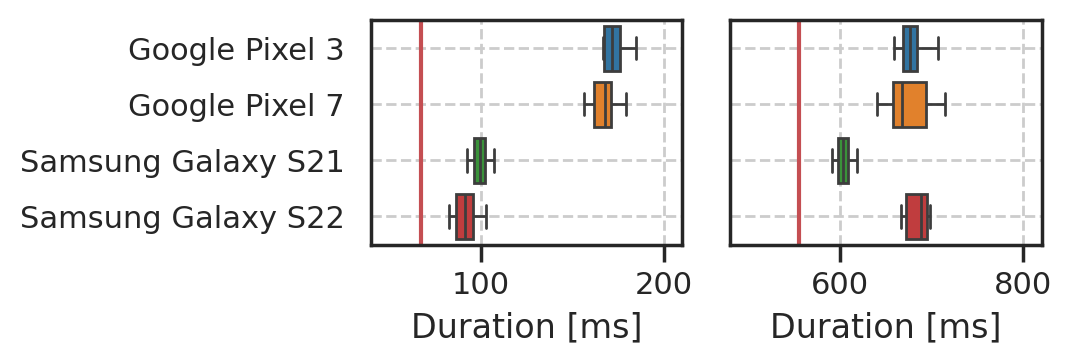

In [3]:
#
# Box plot with the Android LongSloth execution times
#

fig, axs = plt.subplots(1,2)
fig.set_size_inches((5.5, 2.0))

ax1, ax2 = axs

sns.boxplot(
    data=df[df.test=='small'],
    y='name',
    x='duration',
    hue='name',
    ax=ax1,
    showfliers = False,
    dodge=False,
)
ax1.axvline(x=67, color='r')
ax1.set_xlim((40, 210))
ax1.set_xlabel("Duration [ms]")
ax1.set_ylabel(None)
ax1.grid(ls='--')
ax1.legend().remove()


sns.boxplot(
    data=df[df.test=='large'],
    y='name',
    x='duration',
    hue='name',
    ax=ax2,
    showfliers = False,
    dodge=False,
)
ax2.axvline(x=555, color='r')
ax2.set_xlim((480, 820))
ax2.set_xlabel("Duration [ms]")
ax2.set_yticklabels([])
ax2.set_ylabel(None)
ax2.grid(ls='--')
ax2.legend().remove()

fig.tight_layout()
fig.savefig("output/android-long-sloth-box-plot.pdf", dpi=300, bbox_inches='tight')